In [4]:
import pandas as pd
import numpy as np
from openpyxl.workbook import Workbook as wb
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.utils.dataframe import dataframe_to_rows
import scipy
from scipy.stats.stats import pearsonr
import scipy.stats
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Pitchers-Team to wins/winpct correlations and simpe stats
df = pd.read_excel('MLBtotalsPitching2019.xlsx')
df.columns

Index(['Team', 'AVG', 'OBP', 'SLG', 'OPS', 'Spd', 'K/9', 'HR/9', 'K%', 'AVG.1',
       'WHIP', 'SIERA', 'W', 'L', 'PCT', 'HOME', 'AWAY', 'RS', 'RA', 'DIFF',
       'Exp Win pct', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent',
       'max_hit_speed', 'avg_hit_speed', 'fbld', 'gb', 'max_distance',
       'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels',
       'brl_percent', 'brl_pa'],
      dtype='object')

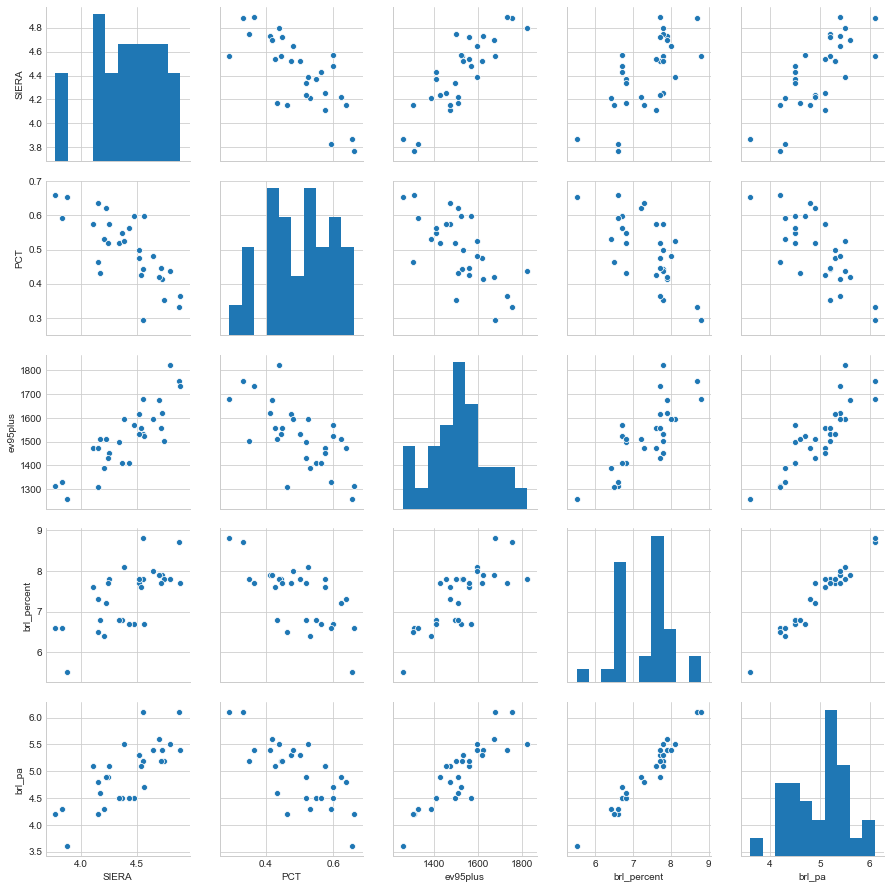

In [6]:
#Data Visualization for Different Variables according to team pitchers stats 2019(SIERA, Win Pct, exit velocity over 95 mph, barrel per batted ball events, and barrel per plate appearance)
#Negative correlations are subject to pitching stats with winning (you want low ERA, opposing exit velos, etc.)
%matplotlib inline
rcParams['figure.figsize'] = 8,4
plt.style.use('seaborn-whitegrid')
X = df[['SIERA','PCT','ev95plus','brl_percent','brl_pa']]
sb.pairplot(X)

In [7]:
Y = df[['PCT', 'SIERA','K/9', 'HR/9', 'K%', 'AVG.1',
       'WHIP','avg_hit_angle','anglesweetspotpercent',
       'max_hit_speed', 'avg_hit_speed', 'fbld', 'gb', 'max_distance',
       'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels',
       'brl_percent', 'brl_pa']]
corr = Y.corr()
corr

,PCT,SIERA,K/9,HR/9,AVG.1,WHIP,avg_hit_angle,anglesweetspotpercent,max_hit_speed,avg_hit_speed,fbld,gb,max_distance,avg_distance,avg_hr_distance,ev95plus,ev95percent,barrels,brl_percent,brl_pa
PCT,1.000000,-0.744593,0.590108,-0.637338,-0.701232,-0.766008,-0.133050,-0.346566,0.102852,-0.606595,-0.640736,-0.482287,-0.073216,-0.488465,-0.093072,-0.671653,-0.635248,-0.742999,-0.690049,-0.726212
SIERA,-0.744593,1.000000,-0.904629,0.622377,0.807926,0.862581,0.127347,0.432023,0.003221,0.674856,0.736225,0.570172,0.195033,0.374594,0.419281,0.849111,0.767705,0.785625,0.674449,0.760265
K/9,0.590108,-0.904629,1.000000,-0.504141,-0.697551,-0.657181,-0.058581,-0.275003,-0.126482,-0.636589,-0.710038,-0.568408,-0.218609,-0.197921,-0.473701,-0.848127,-0.742813,-0.676633,-0.513647,-0.667982
HR/9,-0.637338,0.622377,-0.504141,1.000000,0.650551,0.670916,0.177783,0.479002,0.150463,0.649734,0.609592,0.547767,-0.001404,0.520597,-0.018372,0.657149,0.651701,0.755387,0.712889,0.727637
AVG.1,-0.701232,0.807926,-0.697551,0.650551,1.000000,0.954606,-0.071313,0.593157,0.095187,0.726225,0.705280,0.622077,0.036724,0.329301,0.327919,0.887231,0.796703,0.840695,0.740111,0.803228
WHIP,-0.766008,0.862581,-0.657181,0.670916,0.954606,1.000000,-0.046690,0.568868,0.003638,0.697443,0.689530,0.594144,0.093004,0.362210,0.325371,0.826699,0.759971,0.821587,0.747524,0.776458
avg_hit_angle,-0.133050,0.127347,-0.058581,0.177783,-0.071313,-0.046690,1.000000,0.190737,-0.052801,0.056921,0.107693,-0.046148,-0.257612,0.764217,-0.379318,-0.032021,-0.048017,0.232720,0.304692,0.265852
anglesweetspotpercent,-0.346566,0.432023,-0.275003,0.479002,0.593157,0.568868,0.190737,1.000000,-0.086316,0.459937,0.477577,0.259872,-0.241630,0.576207,0.103681,0.489872,0.467301,0.630952,0.645870,0.613501
max_hit_speed,0.102852,0.003221,-0.126482,0.150463,0.095187,0.003638,-0.052801,-0.086316,1.000000,0.311141,0.080379,0.428438,0.272002,-0.110362,-0.030107,0.151610,0.147934,0.049858,-0.000202,0.039087
avg_hit_speed,-0.606595,0.674856,-0.636589,0.649734,0.726225,0.697443,0.056921,0.459937,0.311141,1.000000,0.863357,0.938252,-0.083942,0.456611,0.212902,0.865643,0.922971,0.839646,0.802569,0.841723


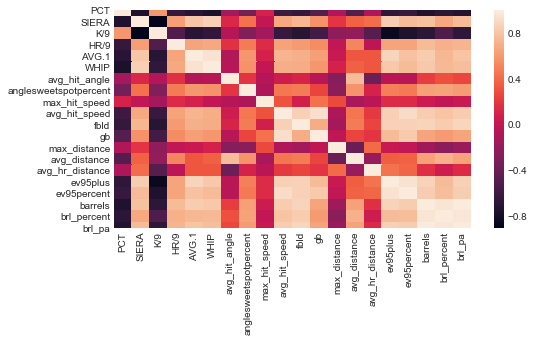

In [49]:
sb.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [11]:
#finding multiple regression to SIERA 
y = df['SIERA'].values
x = df[['brl_pa','avg_hit_speed','ev95plus']] 
regr = linear_model.LinearRegression()
regr.fit(x, y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

Intercept: 
 13.717699583488077
Coefficients: 
 [ 0.11723712 -0.14844053  0.00209362]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              7090.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):                    3.31e-39
Time:                        00:24:21   Log-Likelihood:                          12.890
No. Observations:                  30   AIC:                                     -19.78
Df Residuals:                      27   BIC:                                     -15.58
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std er

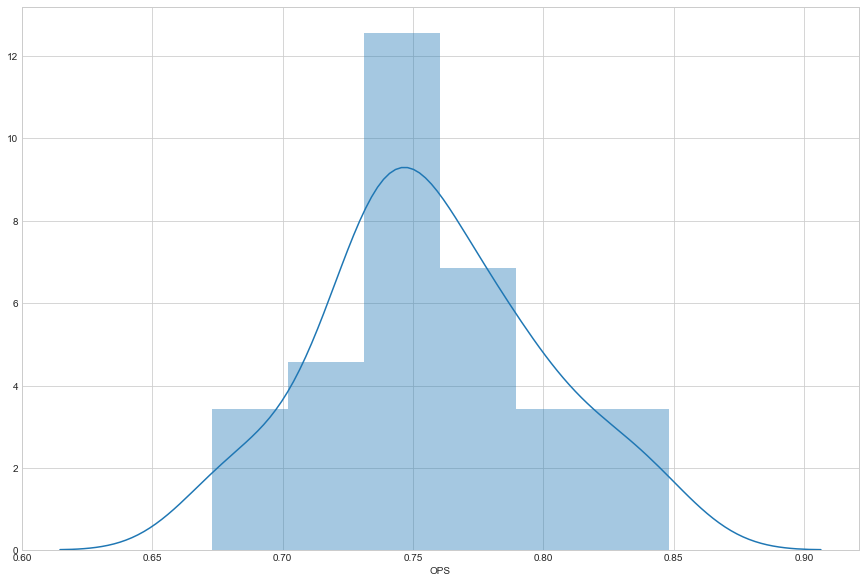

In [12]:
#labeling all of my independent and dependent variables for multiple regression on SIERA (dep variable)
x = df[['avg_hit_angle','anglesweetspotpercent',
       'max_hit_speed', 'avg_hit_speed', 'fbld', 'gb', 'max_distance',
       'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels',
       'brl_percent', 'brl_pa']].values
y = df['SIERA'].values
#to see the average value of win percentage
plt.figure(figsize=(15,10))
plt.tight_layout()
sb.distplot(df['OPS'])